<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S7-Assignment/EVA_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline
import random # for random image index
import torch.nn as nn # for network


from tqdm import tqdm # for beautiful model training updates
from model import Network

Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### 1. Loading Data



In [3]:
## downloading training data, using this to calculate mean and standard deviation 

train_mean_std_dev = datasets.CIFAR10(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.ToTensor()# converts to tesnor
    )

Files already downloaded and verified


In [4]:
train_mean_std_dev.data.shape  ## looking at the shape of the data

(50000, 32, 32, 3)

In [5]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset
def get_mean_std_dev(dataset):
  '''
  reference : https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
  '''

  data = dataset.data / 255 # data is numpy array

  mean = data.mean(axis = (0,1,2)) 
  std = data.std(axis = (0,1,2))
  # print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]
  return tuple(mean), tuple(std)



mean, std_dev = get_mean_std_dev(train_mean_std_dev)
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]


Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [6]:
!pip install -U albumentations

import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2

def apply_transforms(mean,std_dev):
    train_transforms = A.Compose([
        A.HorizontalFlip(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple((x * 255.0 for x in mean)), p=0.2,
        ),
        A.ToGray(p=0.15),
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]


train_transforms, test_transforms = apply_transforms(mean,std_dev)

In [7]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean, std_dev)])

batch_size = 128
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Visualizing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  frog truck  frog plane  ship plane  deer  bird  deer horse truck  deer  bird   cat  bird   dog  frog   car  bird  ship horse  frog   cat  frog horse plane truck  frog   cat  ship   dog   cat truck plane   car  ship horse   dog   car horse truck plane  frog horse plane  ship  ship   car  ship  bird  deer  bird  deer  deer  frog   dog  frog plane  ship  ship horse  bird horse   cat   dog  bird  ship   car  bird   car horse   dog truck   cat  ship   car  ship  deer  ship  bird  frog   dog   car   cat truck   dog  ship  frog plane  bird  bird   cat horse  bird   car   car   cat  ship  frog  ship horse  ship   dog  bird plane   cat  bird truck plane plane  deer  deer horse   car  bird horse truck truck   dog   car   cat  ship  bird  bird   car  ship  ship


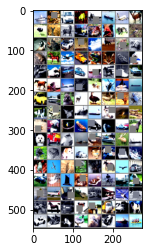

In [8]:
import matplotlib.pyplot as plt # for visualizing images
import numpy as np
import torchvision

def imshow(img):
  '''
  function to show an image
  '''
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 2. Network
Defining CNN

In [9]:
# import torch
# import torch.nn as nn # for network
# import torch.nn.functional as F # for forward method

# drop_out_value = 0.1

# class Network(nn.Module):
#     def __init__(self):
#       super(Network,self).__init__() # extending super class method

#       # Input block
#       self.convblock_input= nn.Sequential(
#         nn.Conv2d(3,32,3,padding=1), # In- 3x32x32, Out- 32x32x32, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # CONV BLOCK 1
#       self.convblock1 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )

#       # TRANSITION BLOCK 1
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock1 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x32x32, Out- 32x16x16, RF- 9x9, Jump_in -1, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # CONV BLOCK 2
#       # Depthwise Separable Convolution Layer
#       self.convblock2 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1,groups=32),# In- 32x16x16, Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
#         nn.Conv2d(32,32,1,padding=0), # In-32x16x16 , Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In-32x16x16 , Out-32x16x16 , RF- 17x17, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # TRANSITION BLOCK 2
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock2 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x16x16, Out-32x8x8 , RF- 21x21, Jump_in -2, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
        
      
#       # CONV BLOCK 3
#       # Dilated Convolution Layer
#       self.convblock3 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1,dilation=2),# In- 32x8x8, Out-32x6x6 , RF- 29x29, Jump_in -4, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In-32x6x6 , Out- 32x6x6, RF- 37x37, Jump_in -4, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # TRANSITION BLOCK 3
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock3 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In-32x6x6 , Out-32x3x3 , RF- 45x45, Jump_in -4, Jump_out -8
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )   

#       # CONV BLOCK 4
#       # Depthwise Separable Convolution Layer
#       self.convblock4 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1), # In- 32x3x3, Out-32x3x3 , RF- 61x61, Jump_in -8, Jump_out -8
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1,groups=32), # In-32x3x3 , Out-32x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
#         nn.Conv2d(32,10,1,padding=0) # In- 32x3x3, Out-10x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
#         # , 
#         # nn.ReLU(),
#         # nn.BatchNorm2d(10),
#         # nn.Dropout(drop_out_value)
#         )
      
#       # Output BLOCK 
#       # GAP Layer
#       self.gap = nn.AvgPool2d(3) # In- 10x3x3, Out-10x1x1 , RF- 77x77, Jump_in -8, Jump_out -8


#     def forward(self, x):
#       x = self.convblock_input(x)
#       x = self.convblock1(x)
#       x = self.transitionblock1(x)
#       x = self.convblock2(x)
#       x = self.transitionblock2(x)
#       x = self.convblock3(x)
#       x = self.transitionblock3(x)
#       x = self.convblock4(x)
#       x = self.gap(x)

#       x = x.view(-1, 10)

#       return F.log_softmax(x, dim=1)

#### Model Params
Checking the model summary and number of parameters


In [10]:
device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Network().to(device)
# print(model)

# !pip install torchsummary
from torchsummary import summary # for model summary and params
summary(model, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1

### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [11]:
import torch.optim as optim # for optimizer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)

In [13]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [14]:
EPOCHS = 100
# EPOCHS = 2

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)



EPOCH: 1


Loss=2.165595769882202 Batch_id=390 Accuracy=14.22: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s]



Test set: Average loss: 0.0002, Accuracy: 2088/10000 (20.88%)

EPOCH: 2


Loss=1.975295066833496 Batch_id=390 Accuracy=22.18: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.0002, Accuracy: 2692/10000 (26.92%)

EPOCH: 3


Loss=1.7130063772201538 Batch_id=390 Accuracy=30.75: 100%|██████████| 391/391 [00:35<00:00, 10.86it/s]



Test set: Average loss: 0.0002, Accuracy: 3602/10000 (36.02%)

EPOCH: 4


Loss=1.4939587116241455 Batch_id=390 Accuracy=36.59: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]



Test set: Average loss: 0.0002, Accuracy: 3990/10000 (39.90%)

EPOCH: 5


Loss=1.6052026748657227 Batch_id=390 Accuracy=41.66: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]



Test set: Average loss: 0.0001, Accuracy: 4744/10000 (47.44%)

EPOCH: 6


Loss=1.6149202585220337 Batch_id=390 Accuracy=47.08: 100%|██████████| 391/391 [00:32<00:00, 12.00it/s]



Test set: Average loss: 0.0001, Accuracy: 5342/10000 (53.42%)

EPOCH: 7


Loss=1.1601707935333252 Batch_id=390 Accuracy=50.72: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s]



Test set: Average loss: 0.0001, Accuracy: 5787/10000 (57.87%)

EPOCH: 8


Loss=1.0233395099639893 Batch_id=390 Accuracy=53.93: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]



Test set: Average loss: 0.0001, Accuracy: 6093/10000 (60.93%)

EPOCH: 9


Loss=1.0781785249710083 Batch_id=390 Accuracy=56.54: 100%|██████████| 391/391 [00:36<00:00, 10.86it/s]



Test set: Average loss: 0.0001, Accuracy: 6106/10000 (61.06%)

EPOCH: 10


Loss=1.3306138515472412 Batch_id=390 Accuracy=58.51: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]



Test set: Average loss: 0.0001, Accuracy: 6483/10000 (64.83%)

EPOCH: 11


Loss=0.9797202348709106 Batch_id=390 Accuracy=60.08: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.0001, Accuracy: 6649/10000 (66.49%)

EPOCH: 12


Loss=1.1765378713607788 Batch_id=390 Accuracy=61.67: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.0001, Accuracy: 6807/10000 (68.07%)

EPOCH: 13


Loss=0.9806040525436401 Batch_id=390 Accuracy=63.34: 100%|██████████| 391/391 [00:36<00:00, 10.84it/s]



Test set: Average loss: 0.0001, Accuracy: 6952/10000 (69.52%)

EPOCH: 14


Loss=1.1229612827301025 Batch_id=390 Accuracy=64.25: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]



Test set: Average loss: 0.0001, Accuracy: 7020/10000 (70.20%)

EPOCH: 15


Loss=0.9904441833496094 Batch_id=390 Accuracy=65.36: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.0001, Accuracy: 7146/10000 (71.46%)

EPOCH: 16


Loss=1.0818796157836914 Batch_id=390 Accuracy=66.56: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]



Test set: Average loss: 0.0001, Accuracy: 7181/10000 (71.81%)

EPOCH: 17


Loss=0.9537164568901062 Batch_id=390 Accuracy=67.27: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.0001, Accuracy: 7353/10000 (73.53%)

EPOCH: 18


Loss=0.8114280700683594 Batch_id=390 Accuracy=68.27: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.0001, Accuracy: 7413/10000 (74.13%)

EPOCH: 19


Loss=1.013279676437378 Batch_id=390 Accuracy=68.96: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.0001, Accuracy: 7427/10000 (74.27%)

EPOCH: 20


Loss=0.8541051149368286 Batch_id=390 Accuracy=69.31: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0001, Accuracy: 7520/10000 (75.20%)

EPOCH: 21


Loss=0.97906094789505 Batch_id=390 Accuracy=70.12: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 7611/10000 (76.11%)

EPOCH: 22


Loss=0.7719008326530457 Batch_id=390 Accuracy=70.40: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.0001, Accuracy: 7640/10000 (76.40%)

EPOCH: 23


Loss=0.7714158296585083 Batch_id=390 Accuracy=70.87: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]



Test set: Average loss: 0.0001, Accuracy: 7662/10000 (76.62%)

EPOCH: 24


Loss=0.742726743221283 Batch_id=390 Accuracy=71.67: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]



Test set: Average loss: 0.0001, Accuracy: 7706/10000 (77.06%)

EPOCH: 25


Loss=1.057157278060913 Batch_id=390 Accuracy=71.97: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]



Test set: Average loss: 0.0001, Accuracy: 7703/10000 (77.03%)

EPOCH: 26


Loss=1.1241466999053955 Batch_id=390 Accuracy=72.27: 100%|██████████| 391/391 [00:32<00:00, 12.00it/s]



Test set: Average loss: 0.0001, Accuracy: 7789/10000 (77.89%)

EPOCH: 27


Loss=0.7918491363525391 Batch_id=390 Accuracy=72.92: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s]



Test set: Average loss: 0.0001, Accuracy: 7817/10000 (78.17%)

EPOCH: 28


Loss=0.8274529576301575 Batch_id=390 Accuracy=73.23: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]



Test set: Average loss: 0.0001, Accuracy: 7833/10000 (78.33%)

EPOCH: 29


Loss=0.7235460877418518 Batch_id=390 Accuracy=73.42: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]



Test set: Average loss: 0.0000, Accuracy: 7863/10000 (78.63%)

EPOCH: 30


Loss=0.6820881366729736 Batch_id=390 Accuracy=73.49: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0001, Accuracy: 7864/10000 (78.64%)

EPOCH: 31


Loss=0.7676984667778015 Batch_id=390 Accuracy=73.86: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 7939/10000 (79.39%)

EPOCH: 32


Loss=0.8011242747306824 Batch_id=390 Accuracy=73.95: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0001, Accuracy: 7955/10000 (79.55%)

EPOCH: 33


Loss=0.5766123533248901 Batch_id=390 Accuracy=74.39: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]



Test set: Average loss: 0.0001, Accuracy: 7990/10000 (79.90%)

EPOCH: 34


Loss=0.7978422045707703 Batch_id=390 Accuracy=74.70: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]



Test set: Average loss: 0.0001, Accuracy: 7996/10000 (79.96%)

EPOCH: 35


Loss=0.8888810276985168 Batch_id=390 Accuracy=74.85: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 7972/10000 (79.72%)

EPOCH: 36


Loss=0.7185099720954895 Batch_id=390 Accuracy=75.22: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.0001, Accuracy: 8062/10000 (80.62%)

EPOCH: 37


Loss=0.7438250780105591 Batch_id=390 Accuracy=75.14: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]



Test set: Average loss: 0.0001, Accuracy: 8054/10000 (80.54%)

EPOCH: 38


Loss=0.7044453620910645 Batch_id=390 Accuracy=75.52: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]



Test set: Average loss: 0.0001, Accuracy: 8054/10000 (80.54%)

EPOCH: 39


Loss=0.7421622276306152 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:36<00:00, 10.86it/s]



Test set: Average loss: 0.0000, Accuracy: 8023/10000 (80.23%)

EPOCH: 40


Loss=0.7293182611465454 Batch_id=390 Accuracy=75.79: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]



Test set: Average loss: 0.0000, Accuracy: 8086/10000 (80.86%)

EPOCH: 41


Loss=0.6156831383705139 Batch_id=390 Accuracy=76.02: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s]



Test set: Average loss: 0.0001, Accuracy: 8101/10000 (81.01%)

EPOCH: 42


Loss=0.5641962289810181 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]



Test set: Average loss: 0.0000, Accuracy: 8166/10000 (81.66%)

EPOCH: 43


Loss=0.6397794485092163 Batch_id=390 Accuracy=76.38: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]



Test set: Average loss: 0.0000, Accuracy: 8160/10000 (81.60%)

EPOCH: 44


Loss=0.7157795429229736 Batch_id=390 Accuracy=76.67: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]



Test set: Average loss: 0.0001, Accuracy: 8175/10000 (81.75%)

EPOCH: 45


Loss=0.5116827487945557 Batch_id=390 Accuracy=76.61: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]



Test set: Average loss: 0.0000, Accuracy: 8170/10000 (81.70%)

EPOCH: 46


Loss=0.7353360652923584 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]



Test set: Average loss: 0.0000, Accuracy: 8192/10000 (81.92%)

EPOCH: 47


Loss=0.6595835089683533 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 0.0000, Accuracy: 8236/10000 (82.36%)

EPOCH: 48


Loss=0.7753931879997253 Batch_id=390 Accuracy=77.42: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]



Test set: Average loss: 0.0001, Accuracy: 8205/10000 (82.05%)

EPOCH: 49


Loss=0.7722424268722534 Batch_id=390 Accuracy=77.25: 100%|██████████| 391/391 [00:35<00:00, 10.96it/s]



Test set: Average loss: 0.0001, Accuracy: 8261/10000 (82.61%)

EPOCH: 50


Loss=0.6735364198684692 Batch_id=390 Accuracy=77.51: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]



Test set: Average loss: 0.0001, Accuracy: 8183/10000 (81.83%)

EPOCH: 51


Loss=0.7725368142127991 Batch_id=390 Accuracy=77.66: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s]



Test set: Average loss: 0.0001, Accuracy: 8233/10000 (82.33%)

EPOCH: 52


Loss=0.745327353477478 Batch_id=390 Accuracy=77.64: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]



Test set: Average loss: 0.0001, Accuracy: 8280/10000 (82.80%)

EPOCH: 53


Loss=0.7917079329490662 Batch_id=390 Accuracy=77.79: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.0001, Accuracy: 8249/10000 (82.49%)

EPOCH: 54


Loss=0.4208225607872009 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]



Test set: Average loss: 0.0001, Accuracy: 8277/10000 (82.77%)

EPOCH: 55


Loss=0.5304173231124878 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8270/10000 (82.70%)

EPOCH: 56


Loss=0.5352320671081543 Batch_id=390 Accuracy=78.17: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 0.0001, Accuracy: 8284/10000 (82.84%)

EPOCH: 57


Loss=0.6158726215362549 Batch_id=390 Accuracy=78.31: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.0001, Accuracy: 8306/10000 (83.06%)

EPOCH: 58


Loss=0.6567283272743225 Batch_id=390 Accuracy=78.35: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.0001, Accuracy: 8309/10000 (83.09%)

EPOCH: 59


Loss=0.6829368472099304 Batch_id=390 Accuracy=78.37: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s]



Test set: Average loss: 0.0000, Accuracy: 8313/10000 (83.13%)

EPOCH: 60


Loss=0.7774664163589478 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]



Test set: Average loss: 0.0000, Accuracy: 8317/10000 (83.17%)

EPOCH: 61


Loss=0.743980348110199 Batch_id=390 Accuracy=78.93: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0000, Accuracy: 8316/10000 (83.16%)

EPOCH: 62


Loss=0.7335264682769775 Batch_id=390 Accuracy=79.06: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]



Test set: Average loss: 0.0000, Accuracy: 8297/10000 (82.97%)

EPOCH: 63


Loss=0.7041515111923218 Batch_id=390 Accuracy=78.95: 100%|██████████| 391/391 [00:36<00:00, 10.86it/s]



Test set: Average loss: 0.0000, Accuracy: 8334/10000 (83.34%)

EPOCH: 64


Loss=0.5774494409561157 Batch_id=390 Accuracy=79.02: 100%|██████████| 391/391 [00:33<00:00, 11.75it/s]



Test set: Average loss: 0.0000, Accuracy: 8342/10000 (83.42%)

EPOCH: 65


Loss=0.5736207962036133 Batch_id=390 Accuracy=79.11: 100%|██████████| 391/391 [00:36<00:00, 10.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8345/10000 (83.45%)

EPOCH: 66


Loss=0.8375198245048523 Batch_id=390 Accuracy=79.09: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 0.0000, Accuracy: 8348/10000 (83.48%)

EPOCH: 67


Loss=0.5296640992164612 Batch_id=390 Accuracy=79.39: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8359/10000 (83.59%)

EPOCH: 68


Loss=0.47995391488075256 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8394/10000 (83.94%)

EPOCH: 69


Loss=0.6549557447433472 Batch_id=390 Accuracy=79.40: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s]



Test set: Average loss: 0.0000, Accuracy: 8359/10000 (83.59%)

EPOCH: 70


Loss=0.5394697785377502 Batch_id=390 Accuracy=79.58: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]



Test set: Average loss: 0.0000, Accuracy: 8391/10000 (83.91%)

EPOCH: 71


Loss=0.6078646183013916 Batch_id=390 Accuracy=79.83: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8406/10000 (84.06%)

EPOCH: 72


Loss=0.6670585870742798 Batch_id=390 Accuracy=79.82: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 0.0001, Accuracy: 8424/10000 (84.24%)

EPOCH: 73


Loss=0.5269523859024048 Batch_id=390 Accuracy=79.91: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s]



Test set: Average loss: 0.0000, Accuracy: 8431/10000 (84.31%)

EPOCH: 74


Loss=0.5200757384300232 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8397/10000 (83.97%)

EPOCH: 75


Loss=0.7794018387794495 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8404/10000 (84.04%)

EPOCH: 76


Loss=0.6846297383308411 Batch_id=390 Accuracy=79.91: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8380/10000 (83.80%)

EPOCH: 77


Loss=0.41841134428977966 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8480/10000 (84.80%)

EPOCH: 78


Loss=0.5677528381347656 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.0000, Accuracy: 8451/10000 (84.51%)

EPOCH: 79


Loss=0.39965713024139404 Batch_id=390 Accuracy=80.14: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s]



Test set: Average loss: 0.0000, Accuracy: 8462/10000 (84.62%)

EPOCH: 80


Loss=0.6461684703826904 Batch_id=390 Accuracy=80.49: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 0.0000, Accuracy: 8474/10000 (84.74%)

EPOCH: 81


Loss=0.5806752443313599 Batch_id=390 Accuracy=80.36: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.0000, Accuracy: 8439/10000 (84.39%)

EPOCH: 82


Loss=0.6523984670639038 Batch_id=390 Accuracy=80.58: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]



Test set: Average loss: 0.0000, Accuracy: 8447/10000 (84.47%)

EPOCH: 83


Loss=0.6026504635810852 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]



Test set: Average loss: 0.0000, Accuracy: 8481/10000 (84.81%)

EPOCH: 84


Loss=0.4314667284488678 Batch_id=390 Accuracy=80.66: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.0000, Accuracy: 8507/10000 (85.07%)

EPOCH: 85


Loss=0.7777124643325806 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8477/10000 (84.77%)

EPOCH: 86


Loss=0.598368763923645 Batch_id=390 Accuracy=80.69: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]



Test set: Average loss: 0.0000, Accuracy: 8468/10000 (84.68%)

EPOCH: 87


Loss=0.6227369904518127 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8471/10000 (84.71%)

EPOCH: 88


Loss=0.5646460652351379 Batch_id=390 Accuracy=80.71: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8473/10000 (84.73%)

EPOCH: 89


Loss=0.6516642570495605 Batch_id=390 Accuracy=80.88: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Test set: Average loss: 0.0000, Accuracy: 8462/10000 (84.62%)

EPOCH: 90


Loss=0.44299620389938354 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]



Test set: Average loss: 0.0000, Accuracy: 8459/10000 (84.59%)

EPOCH: 91


Loss=0.4920811653137207 Batch_id=390 Accuracy=80.76: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s]



Test set: Average loss: 0.0000, Accuracy: 8513/10000 (85.13%)

EPOCH: 92


Loss=0.3990899324417114 Batch_id=390 Accuracy=81.01: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8512/10000 (85.12%)

EPOCH: 93


Loss=0.4136173725128174 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s]



Test set: Average loss: 0.0000, Accuracy: 8512/10000 (85.12%)

EPOCH: 94


Loss=0.5526527166366577 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]



Test set: Average loss: 0.0000, Accuracy: 8520/10000 (85.20%)

EPOCH: 95


Loss=0.44126230478286743 Batch_id=390 Accuracy=80.86: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8535/10000 (85.35%)

EPOCH: 96


Loss=0.800866961479187 Batch_id=390 Accuracy=81.21: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8501/10000 (85.01%)

EPOCH: 97


Loss=0.4272705018520355 Batch_id=390 Accuracy=81.32: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8530/10000 (85.30%)

EPOCH: 98


Loss=0.6045482754707336 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8532/10000 (85.32%)

EPOCH: 99


Loss=0.49902987480163574 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8529/10000 (85.29%)

EPOCH: 100


Loss=0.42623472213745117 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8499/10000 (84.99%)



### 4. Checking results

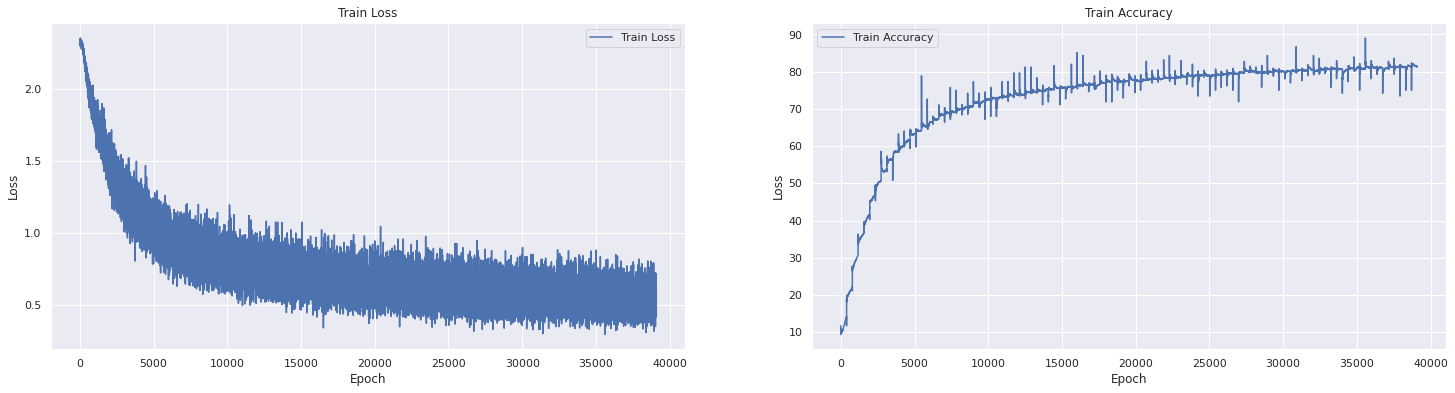

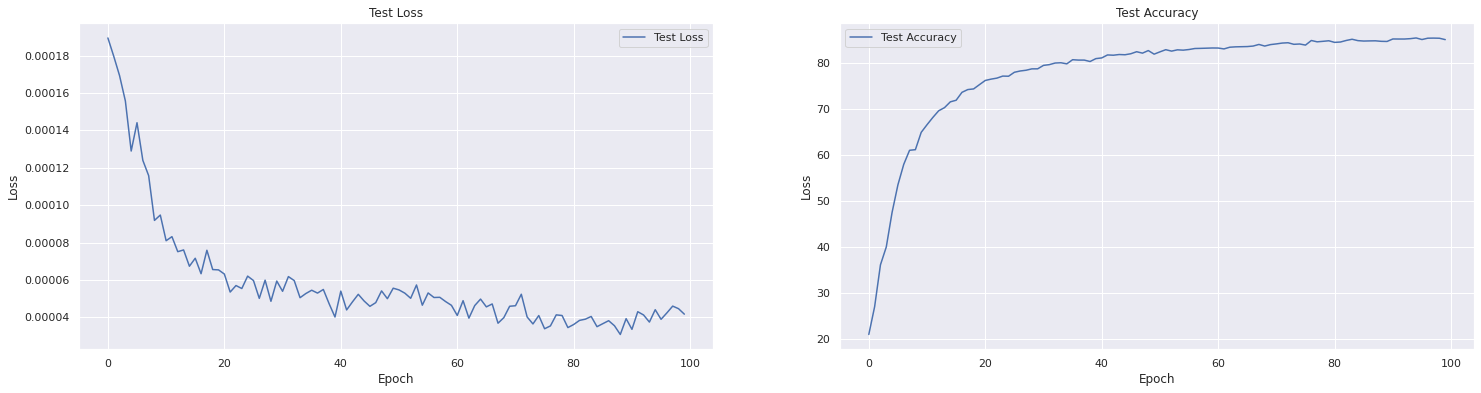

In [15]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")
    
    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")
    
    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")
    
    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")
    
    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   frog   car  frog   cat   car
Predicted:   frog   car  frog   cat   car


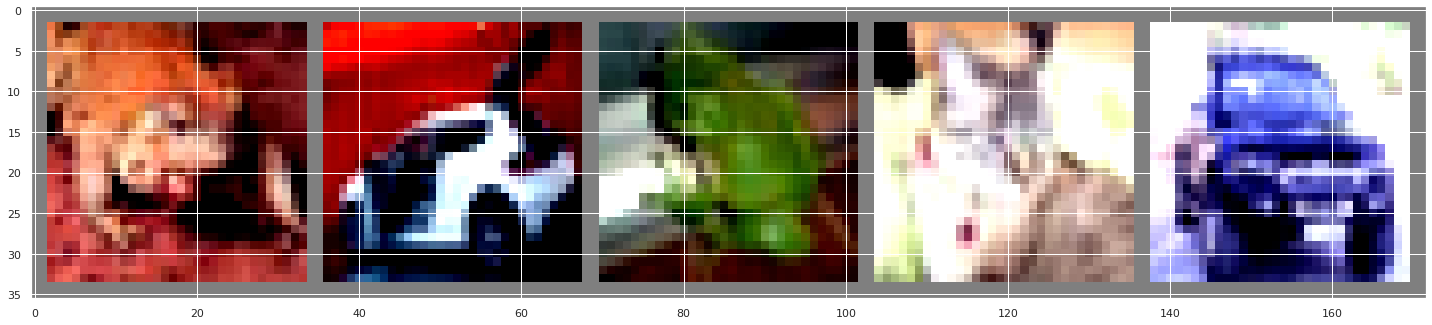

In [16]:
def show_predicted_actual(model, device, dataset, classes):
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# print images
	imshow(torchvision.utils.make_grid(images[img_list]))
	print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	images = images.to(device)
	outputs = model(images)

	_, predicted = torch.max(outputs, 1)
	print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in img_list))
 

show_predicted_actual(model, device, testloader, classes)


In [17]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
      
evaluate_classwise_accuracy(model, device, classes, testloader)


Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 61 %
Accuracy of  deer : 81 %
Accuracy of   dog : 78 %
Accuracy of  frog : 94 %
Accuracy of horse : 88 %
Accuracy of  ship : 87 %
Accuracy of truck : 89 %
